In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from scipy.stats import rankdata, zscore
import os
import joblib

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, auc
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from MTL import train_model

# Data Loading for Model Training

In [5]:
meta_neg = pd.read_csv('meta_neg_sep_hallmark.csv', index_col=(0))
meta_neg['sample'] = meta_neg.index.str.split('&').str[0]
meta_neg.index = [f'Negative_{j+1}' for j in range(len(meta_neg.index))]
meta_neg['Class'] = 0
meta_neg

,Cancer,Hallmark,sample,Class
Negative_1,Ovarian,AID,1,0
Negative_2,Breast,AID,1,0
Negative_3,Ovarian,AID,1,0
Negative_4,Prostate,AIM,1,0
Negative_5,Prostate,AIM,1,0
...,...,...,...,...
Negative_39139,Hematologic,ERI,tFL1,0
Negative_39140,Hematologic,IA,tFL1,0
Negative_39141,Hematologic,IA,tFL1,0
Negative_39142,Hematologic,ERI,tFL2,0


In [6]:
meta_pos = pd.read_csv('meta_pos_sep_hallmark.csv', index_col=(0))
meta_pos['sample'] = meta_pos.index.str.split('&').str[0]
meta_pos.index = [f'Positive_{j+1}' for j in range(len(meta_pos.index))]
meta_pos['Class'] = 1
meta_pos

,Cancer,Hallmark,sample,Class
Positive_1,Ovarian,AIM,1,1
Positive_2,Ovarian,AIM,1,1
Positive_3,Ovarian,AIM,1,1
Positive_4,Ovarian,AIM,1,1
Positive_5,Ovarian,AIM,1,1
...,...,...,...,...
Positive_28783,Hematologic,EGS,tFL2,1
Positive_28784,Hematologic,ERI,tFL2,1
Positive_28785,Hematologic,ERI,tFL2,1
Positive_28786,Hematologic,IA,tFL2,1


In [6]:
data_pos = pd.read_csv('data_pos_sep_hallmark.csv',index_col=(0))
data_pos.index = [f'Positive_{j+1}' for j in range(len(data_pos.index))]
data_pos

,NOC2L,HES4,ISG15,AGRN,TNFRSF18,TNFRSF4,SDF4,B3GALT6,UBE2J2,ACAP3,PUSL1,DVL1,MXRA8,AURKAIP1,CCNL2,MRPL20,ANKRD65,VWA1,ATAD3C,ATAD3B,ATAD3A,SSU72,MIB2,MMP23B,CDK11B,CDK11A,NADK,GNB1,PRKCZ,SKI,RER1,PEX10,TNFRSF14,FAM213B,MMEL1,TPRG1L,WRAP73,SMIM1,LRRC47,CEP104,...,IGLV1-44,IGLV1-40,IGLV3-25,IGLV2-23,IGLV3-21,IGLV3-19,IGLV2-18,IGLV2-14,IGLV2-11,IGLV3-10,IGLV3-9,IGLV2-8,IGLV3-1,IGLC1,IGLC2,IGLC3,IGLC7,Z93241.1,PRR34-AS1,AL118516.1,U62317.5,FP236383.3,GATD3A,AC233755.2,MT-RNR1,MT-RNR2,GAS5,SNHG5,LHFPL3-AS1,SNHG6,AP000676.5,SNHG29,AC090498.1,LRRC75A-AS1,MTCO2P12,C19ORF43,C14ORF2,UQCR11.1,COX1,COX2
Positive_1,91,213,229,12,6,25,119,70,108,8,14,16,5,194,70,232,1,27,2,32,43,258,18,2,35,22,41,275,11,36,141,21,52,0,1,33,18,5,35,27,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Positive_2,109,186,132,15,9,7,132,87,116,11,13,20,2,229,66,268,1,30,5,44,51,313,25,2,23,35,37,335,8,36,153,23,57,0,0,35,9,1,24,24,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Positive_3,125,206,125,22,14,22,154,100,126,14,12,17,9,262,84,284,3,45,5,33,49,421,17,0,36,33,34,372,16,39,167,16,56,0,2,28,19,3,42,38,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Positive_4,112,167,177,20,8,11,145,101,121,13,16,20,9,217,70,244,2,19,3,44,43,354,17,2,25,33,34,372,20,38,194,17,56,0,1,37,16,2,30,19,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Positive_5,109,234,159,15,10,23,141,56,120,10,7,22,11,267,69,259,0,31,1,37,50,312,21,2,36,37,40,348,11,40,169,16,56,0,1,22,17,2,45,27,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Positive_28783,18,3,26,0,20,35,41,4,31,3,6,0,0,56,32,47,1,0,3,3,3,67,20,1,15,18,8,22,6,1,48,6,36,0,0,8,26,1,12,7,...,0,0,2,0,0,0,0,0,0,0,0,0,0,0,92,17,6,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Positive_28784,16,0,13,1,0,0,24,3,23,2,4,0,0,44,29,53,0,0,2,8,9,79,10,0,13,13,11,10,5,0,39,8,37,0,0,4,22,0,12,12,...,0,0,3,0,0,0,0,0,0,0,0,0,0,0,136,18,6,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Positive_28785,29,0,19,0,0,5,32,3,30,2,6,1,0,65,41,45,1,0,3,3,6,76,12,0,15,15,7,17,4,1,37,5,33,0,0,12,18,0,11,14,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,134,12,11,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Positive_28786,25,0,22,0,8,17,27,3,30,4,2,0,0,57,41,58,0,0,1,5,6,75,14,1,19,19,8,17,3,1,31,9,39,0,0,8,23,0,10,22,...,0,0,3,0,0,0,0,0,0,0,0,0,0,0,139,21,7,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
data_neg = pd.read_csv('data_neg_sep_hallmark.csv',index_col=(0))
data_neg.index = [f'Negative_{j+1}' for j in range(len(data_neg.index))]
data_neg

,SAMD11,NOC2L,HES4,ISG15,AGRN,TNFRSF18,TNFRSF4,SDF4,B3GALT6,C1QTNF12,UBE2J2,ACAP3,PUSL1,INTS11,CPTP,DVL1,MXRA8,AURKAIP1,CCNL2,MRPL20,ANKRD65,VWA1,ATAD3C,ATAD3B,ATAD3A,SSU72,MIB2,MMP23B,CDK11B,SLC35E2B,CDK11A,NADK,GNB1,PRKCZ,FAAP20,SKI,RER1,PEX10,TNFRSF14,MMEL1,...,RAMMET,SMIM37,Z93241.1,AC020656.1,AC004148.2,AC005921.2,AC009414.2,AL157938.3,AL603756.1,AP003086.1,AC010967.1,AC114760.2,AC137932.3,AL133453.1,AL512274.1,AC109466.1,LPHN3,IGJ,BAI3,GAS5,AC011246.1,EEF1AKMT4,LHFPL3-AS1,AC068587.4,AC103724.4,LINC00476,AP000676.5,AC023034.1,HNRNPA1P48,SNHG29,PPP1R2C,AC073111.5,AL117339.5,MTCO2P12,MT-RNR1,MT-RNR2,COX1,COX2,COX3,ND4
Negative_1,3,39,66,63,5,3,1,47,22,0,32,6,4,16,3,6,17,51,30,75,3,4,1,23,18,89,10,3,11,5,15,13,31,3,28,10,47,7,8,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,7,0,0,4,0,0,0,0,0,0,0,0,0,0,0
Negative_2,0,6,5,201,0,65,139,8,0,0,8,0,2,9,3,0,0,19,10,22,0,0,0,0,1,32,7,0,1,3,2,3,0,1,10,1,23,0,11,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Negative_3,11,34,79,41,5,6,10,54,13,3,39,5,2,17,8,11,13,81,30,79,3,1,2,17,16,123,2,5,13,3,17,17,37,1,24,16,45,6,9,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,9,0,0,10,0,0,0,0,0,0,0,0,0,0,0
Negative_4,1,14,36,27,1,0,0,33,4,0,9,1,4,0,1,5,0,50,16,51,0,7,1,5,2,36,4,0,6,5,5,4,15,6,14,4,17,8,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Negative_5,0,9,35,29,3,0,1,29,3,0,4,3,3,0,1,4,0,41,22,28,0,10,0,0,3,34,6,1,10,4,7,13,12,7,16,7,20,3,3,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Negative_39139,0,12,4,76,0,17,37,14,6,0,24,0,5,16,4,1,0,42,16,25,0,0,1,2,4,60,19,1,19,13,19,12,20,3,33,5,27,2,26,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Negative_39140,1,9,2,71,0,11,9,12,2,0,9,3,4,16,5,0,0,46,17,25,0,0,1,4,5,66,19,2,15,7,14,10,19,7,27,1,26,1,21,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Negative_39141,0,3,2,129,3,25,34,24,8,0,15,0,2,19,5,1,0,38,13,42,0,0,4,5,4,50,8,3,14,4,22,17,10,6,23,5,31,3,18,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Negative_39142,0,22,0,33,0,29,33,33,2,0,26,3,3,24,8,2,0,43,27,45,1,0,2,5,4,86,11,1,20,12,14,13,15,4,23,1,43,6,42,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
common = (list(set(data_pos.columns) & set(data_neg.columns)))
len(common)

9326

In [ ]:
# with open("hallmark_feature.txt", "w") as file:
#     for item in common:
#         file.write(f"{item}\n")

In [9]:
data_pos1 = data_pos[common]
col_val = data_pos1.columns
row_val = data_pos1.index
data_pos1 = rankdata(data_pos1 * -1, axis=1, method='average')
data_pos1 = pd.DataFrame(data_pos1)
data_pos1.columns = col_val
data_pos1.index = row_val
data_pos1 = np.log2(data_pos1)
data_pos1

,ARID3B,MTMR6,GBE1,LTBP1,RBMX2,WTAP,ORC4,GJA4,SRP9,CARD16,GOT1,FOXP1,EIF4EBP2,HAUS3,TRAPPC8,PTPN23,NOC2L,CEP57,BOP1,PCSK7,EFNB1,TROVE2,HDGFL2,CACNB3,SEC23A,YTHDC1,MYCBP2,HPN,MITD1,SUPT7L,RNFT1,CPVL,FKBP11,ODF2,NEU1,ARRDC3,NDUFAF6,ANO6,USP7,RNF26,...,VPS4B,CDKN1C,ATRAID,ABHD5,CES2,FTO,UBAC2,MACF1,PRKCI,SH3BGRL,THEMIS2,ANKRD49,TRMT1L,AREG,TFEB,TMEM129,CD40LG,IGHV3-15,IGSF6,NUP50,ERP29,NCBP3,COL16A1,BCR,NUP153,CACUL1,TAP1,DRAM2,SELENOH,DENND6B,EEF1A1,BTBD7,SGTA,EIF2B1,VGLL4,BTN3A1,BCAR1,GALK1,TIMM13,LAMC2
Positive_1,12.911392,11.875557,11.635265,11.543998,12.014718,8.179909,12.378837,12.154660,9.845490,12.857689,11.993292,10.394463,12.298206,12.672646,12.378837,12.378837,11.153869,12.406736,12.085306,11.303495,10.663113,13.138112,12.593858,12.989572,11.461735,10.230020,10.806147,13.016547,12.457637,12.722594,12.535640,12.938477,11.061034,12.565221,11.523562,11.188280,12.378837,11.256504,10.872290,12.911392,...,11.819181,11.615400,10.676839,11.188280,12.321505,12.722594,12.014718,8.899357,12.062721,10.627534,13.042942,12.272921,12.911392,11.800900,12.779001,12.911392,13.138112,13.138112,13.138112,11.615400,10.782589,11.486835,12.748717,12.127994,11.363861,11.272630,10.714675,12.347345,10.756973,12.989572,1.584963,10.836050,11.287424,12.246889,10.000704,12.911392,10.806147,13.016547,10.568906,8.961450
Positive_2,12.822272,11.529675,11.513234,11.821774,12.054435,7.727920,12.357415,12.772315,10.013323,12.748298,11.630950,10.229420,12.200439,12.675516,12.222342,12.381002,10.997179,12.478643,11.915319,11.156083,10.195372,13.134747,12.650715,12.954015,11.063732,10.432020,10.381543,13.007903,12.625823,12.722701,12.822272,12.796344,10.852530,12.453399,11.935349,10.868437,12.796344,11.393390,10.939212,12.698379,...,11.895386,12.093748,11.224002,10.997179,12.407268,12.625823,12.311323,9.208234,11.821774,11.156083,12.869787,12.625823,12.822272,12.576012,12.675516,12.869787,13.134747,13.134747,13.063901,11.499098,11.409391,11.804938,12.822272,12.286558,11.240791,11.063732,10.651052,12.748298,10.668885,12.981121,2.000000,10.966866,11.350110,12.430060,9.800900,13.007903,10.668885,12.954015,10.852530,9.972262
Positive_3,12.884457,11.726218,11.228819,12.119752,12.279320,8.076816,12.426789,12.450696,9.902375,12.839991,11.372865,10.154185,11.917559,12.718105,12.516931,12.196909,10.935165,12.403811,12.176017,11.228819,9.919608,13.138032,12.743257,13.021848,11.690435,10.046442,10.472691,12.743257,12.426789,12.584728,12.743257,12.997709,11.203960,12.472437,11.674192,11.026523,12.426789,11.330077,10.779309,12.743257,...,11.500593,12.016286,10.495355,11.186424,12.403811,12.605480,12.103124,9.125413,11.674192,10.649256,13.138032,12.670656,12.972890,11.999295,12.861669,12.817683,13.138032,13.138032,13.047720,11.858564,10.649256,11.674192,12.972890,12.155925,11.541581,11.171802,10.428884,12.605480,10.607330,12.972890,1.584963,10.881496,11.726218,12.584728,9.776433,12.906421,10.756556,12.997709,10.438272,9.255029
Positive_4,12.839696,11.672425,10.976922,11.732803,11.994177,7.971544,12.427968,12.576484,10.078151,12.739886,11.749869,9.723661,12.052908,12.622166,12.494856,12.576484,11.097703,12.474466,11.939579,11.355902,10.310045,13.136430,12.715211,12.971723,11.323336,10.158610,10.597587,13.015763,12.427968,12.691198,12.786474,12.929906,11.022715,12.622166,11.975669,10.742730,12.404742,10.950191,10.606868,12.762486,...,11.437492,12.317271,10.541581,11.239897,12.451340,12.622166,12.297346,8.688250,11.920911,10.987619,13.067938,12.537825,12.863412,12.278014,12.644420,12.907360,13.067938,13.136430,13.039947,11.866506,10.829723,11.600842,12.863412,12.381273,11.265322,11.292034,10.424691,12.576484,10.627078,12.992584,2.000000,10.998943,11.450180,12.494856,9.797662,13.039947,10.694358,13.039947,10.703038,9.332037
Positive_5,12.884934,11.309476,11.620449,11.620449,12.043027,7.864186,12.403944,12.296629,9.955650,12.789737,11.620449,10.115694,12.009304,12.812378,12.317554,12.510146,11.108524,12.531625,12.381543,11.121534,10.634357,13.137472,12.720030,13.024101,11.445

In [10]:
data_neg1 = data_neg[common]
col_val = data_neg1.columns
row_val = data_neg1.index
data_neg1 = rankdata(data_neg1 * -1, axis=1, method='average')
data_neg1 = pd.DataFrame(data_neg1)
data_neg1.columns = col_val
data_neg1.index = row_val
data_neg1 = np.log2(data_neg1)
data_neg1

,ARID3B,MTMR6,GBE1,LTBP1,RBMX2,WTAP,ORC4,GJA4,SRP9,CARD16,GOT1,FOXP1,EIF4EBP2,HAUS3,TRAPPC8,PTPN23,NOC2L,CEP57,BOP1,PCSK7,EFNB1,TROVE2,HDGFL2,CACNB3,SEC23A,YTHDC1,MYCBP2,HPN,MITD1,SUPT7L,RNFT1,CPVL,FKBP11,ODF2,NEU1,ARRDC3,NDUFAF6,ANO6,USP7,RNF26,...,VPS4B,CDKN1C,ATRAID,ABHD5,CES2,FTO,UBAC2,MACF1,PRKCI,SH3BGRL,THEMIS2,ANKRD49,TRMT1L,AREG,TFEB,TMEM129,CD40LG,IGHV3-15,IGSF6,NUP50,ERP29,NCBP3,COL16A1,BCR,NUP153,CACUL1,TAP1,DRAM2,SELENOH,DENND6B,EEF1A1,BTBD7,SGTA,EIF2B1,VGLL4,BTN3A1,BCAR1,GALK1,TIMM13,LAMC2
Negative_1,12.850578,11.531869,11.825555,10.644758,11.979961,8.214319,11.825555,12.721633,9.620220,13.040118,11.679920,9.516685,11.979961,12.390572,12.915413,12.259155,11.057653,11.629584,12.454685,10.700440,11.979961,13.129364,12.087629,12.915413,11.289731,10.290019,11.406471,13.040118,12.259155,12.850578,12.721633,12.654300,10.644758,12.454685,11.137632,11.254733,12.850578,11.020633,11.178665,12.787188,...,11.679920,11.137632,10.583083,10.823367,12.654300,12.654300,11.531869,8.791163,11.774993,9.605480,12.979693,12.654300,12.915413,12.390572,12.787188,12.390572,13.129364,13.129364,12.979693,11.979961,10.262682,11.629584,11.979961,12.787188,11.324743,11.774993,11.725792,12.516808,10.674192,12.850578,1.584963,11.324743,11.679920,12.087629,10.947637,12.979693,10.947637,13.129364,10.611947,10.512247
Negative_2,12.705416,12.487212,12.262976,13.010878,11.153552,10.622509,11.459688,13.010878,8.851749,8.216746,11.153552,10.878817,10.878817,11.635491,12.262976,13.010878,11.635491,11.635491,12.705416,9.703038,12.487212,13.010878,12.705416,13.010878,11.299494,11.017156,10.749450,13.010878,10.225207,12.262976,11.299494,13.010878,10.412041,13.010878,11.829128,9.518653,12.487212,12.705416,12.487212,12.262976,...,11.153552,13.010878,9.703038,12.705416,12.487212,13.010878,11.299494,11.017156,12.705416,9.016808,12.038062,11.635491,11.829128,12.262976,12.705416,13.010878,11.017156,13.010878,13.010878,11.829128,9.457381,12.038062,13.010878,12.487212,13.010878,12.262976,8.688250,11.017156,9.066089,12.038062,4.169925,12.038062,13.010878,12.038062,11.829128,10.622509,13.010878,12.262976,10.504819,13.010878
Negative_3,13.125091,12.135068,11.858175,9.884171,11.910081,8.219169,11.807757,12.443203,9.615630,12.643293,11.707143,9.946175,12.443203,12.443203,12.842841,12.509899,11.236313,12.078985,11.612177,10.416270,11.658881,13.125091,12.778591,12.842841,10.770251,10.233020,11.354525,12.971723,12.712312,12.257535,12.712312,12.971723,10.142107,12.574594,10.948732,11.397407,12.443203,10.738092,10.827740,12.778591,...,11.910081,11.485578,10.575066,10.799686,12.375039,12.971723,12.135068,8.659996,11.858175,9.416798,12.971723,12.643293,12.908111,12.971723,12.643293,12.314583,13.125091,13.125091,13.031357,12.375039,11.236313,11.858175,11.707143,12.712312,10.948732,11.023408,11.658881,12.509899,10.543032,13.125091,2.000000,11.129605,11.443203,12.135068,10.770251,13.031357,10.985842,13.125091,10.661333,11.612177
Negative_4,12.751126,12.362903,12.558899,12.558899,11.298635,10.558421,11.773757,13.025053,9.622052,13.025053,11.961811,8.543032,11.596190,12.161132,11.961811,12.362903,10.659104,11.773757,11.961811,11.441129,13.025053,11.596190,13.025053,12.362903,12.558899,9.782998,12.161132,11.024101,12.161132,12.558899,12.362903,13.025053,9.728771,13.025053,9.893302,11.961811,12.751126,13.025053,11.024101,12.751126,...,11.160817,12.362903,10.558421,12.161132,12.161132,13.025053,11.596190,11.441129,11.441129,9.832890,13.025053,12.362903,13.025053,12.558899,11.773757,10.763627,13.025053,13.025053,12.751126,11.441129,8.202124,12.161132,12.751126,12.751126,12.362903,11.961811,12.558899,10.375583,13.025053,12.751126,4.882643,12.161132,11.961811,11.441129,10.460456,12.751126,11.961811,12.751126,8.243174,12.751126
Negative_5,12.753844,12.360298,12.562839,13.025659,11.420487,11.125091,12.157505,13.025659,9.803324,12.562839,11.960726,8.682995,11.587778,11.960726,12.562839,12.753844,11.272338,12.753844,12.157505,10.717248,13.025659,10.976922,13.025659,12.360298,12.360298,10.00

In [145]:
hall_list = ['AIM', 'DCE', 'EGS', 'GIM', 'RCD', 'SPS', 'AID', 'IA', 'ERI', 'TPI']

In [144]:
cancer_hallmarks = {
    'ERI': 'Evading Replicative Immortality',
    'AIM': 'Activating Invasion and Metastasis',
    'GIM': 'Genome Instability and Mutation',
    'SPS': 'Sustaining Proliferative Signaling',
    'TPI': 'Tumor-Promoting Inflammation',
    'AID': 'Avoiding Immune Destruction',
    'DCE': 'Deregulating Cellular Energetics',
    'RCD': 'Resisting Cell Death',
    'IA': 'Inducing Angiogenesis',
    'EGS': 'Enabling Growth Suppressor'
}

In [16]:
datasets = []
for task, i in enumerate(hall_list):
    meta_pos1 = meta_pos[meta_pos['Hallmark'] == i]
    meta_neg1 = meta_neg[meta_neg['Hallmark'] == i]
    print(i, meta_pos1.shape, meta_neg1.shape)
    hall_pos = data_pos1[data_pos1.index.isin(meta_pos1.index)]
    hall_neg = data_neg1[data_neg1.index.isin(meta_neg1.index)]
    print(i, hall_pos.shape, hall_neg.shape)
    hall_all = pd.concat([hall_pos, hall_neg], axis=0)
    labels = [1] * len(hall_pos) + [0] * len(hall_neg)
    task_labels = [task] * len(hall_all)
    datasets.append((hall_all, labels, task_labels))

AIM (3364, 3) (4184, 3)
AIM (3364, 9326) (4184, 9326)
DCE (3841, 3) (4249, 3)
DCE (3841, 9326) (4249, 9326)
EGS (3724, 3) (3168, 3)
EGS (3724, 9326) (3168, 9326)
GIM (1282, 3) (846, 3)
GIM (1282, 9326) (846, 9326)
RCD (2590, 3) (2833, 3)
RCD (2590, 9326) (2833, 9326)
SPS (3305, 3) (3796, 3)
SPS (3305, 9326) (3796, 9326)
AID (2832, 3) (3671, 3)
AID (2832, 9326) (3671, 9326)
IA (2318, 3) (4334, 3)
IA (2318, 9326) (4334, 9326)
ERI (3205, 3) (7238, 3)
ERI (3205, 9326) (7238, 9326)
TPI (2326, 3) (4824, 3)
TPI (2326, 9326) (4824, 9326)


# Data Loading Done

# Repeated K-Fold Cross Validation

In [121]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
cv_train_data, cv_val_data, cv_test_data = [], [], []
for x, y, t in datasets:
    x = np.array(x)
    y = np.array(y)
    t = np.array(t)
    train_data, val_data, test_data = [], [], []
    for train_ix, test_ix in cv.split(x, y):
        x_train, x_temp = x[train_ix], x[test_ix]
        y_train, y_temp = y[train_ix], y[test_ix]
        t_train, t_temp = t[train_ix], t[test_ix]
        x_test, x_val, y_test, y_val, t_test, t_val = train_test_split(
            x_temp, y_temp, t_temp, test_size=0.5, stratify=y_temp, random_state=42
        )
        train_data.append((x_train, y_train, t_train))
        val_data.append((x_val, y_val, t_val))
        test_data.append((x_test, y_test, t_test))
    cv_train_data.append(train_data)
    cv_val_data.append(val_data)
    cv_test_data.append(test_data)

In [122]:
merged_train_data, merged_val_data, merged_test_data = [], [], []

n_folds = cv.get_n_splits()

for fold_index in range(n_folds):
    fold_train_x, fold_train_y, fold_train_t = [], [], []
    fold_val_x, fold_val_y, fold_val_t = [], [], []
    fold_test_x, fold_test_y, fold_test_t = [], [], []
    
    # Merge the current fold across all datasets
    for dataset_index in range(len(datasets)):
        fold_train_x.append(cv_train_data[dataset_index][fold_index][0])
        fold_train_y.append(cv_train_data[dataset_index][fold_index][1])
        fold_train_t.append(cv_train_data[dataset_index][fold_index][2])
        
        fold_val_x.append(cv_val_data[dataset_index][fold_index][0])
        fold_val_y.append(cv_val_data[dataset_index][fold_index][1])
        fold_val_t.append(cv_val_data[dataset_index][fold_index][2])
        
        fold_test_x.append(cv_test_data[dataset_index][fold_index][0])
        fold_test_y.append(cv_test_data[dataset_index][fold_index][1])
        fold_test_t.append(cv_test_data[dataset_index][fold_index][2])
    
    x_train, y_train, t_train = np.concatenate(fold_train_x), np.concatenate(fold_train_y), np.concatenate(fold_train_t)
    x_val, y_val, t_val = np.concatenate(fold_val_x), np.concatenate(fold_val_y), np.concatenate(fold_val_t)
    x_test, y_test, t_test = np.concatenate(fold_test_x), np.concatenate(fold_test_y), np.concatenate(fold_test_t)
    
    x_train, y_train, t_train = shuffle(x_train, y_train, t_train, random_state=42)
    x_val, y_val, t_val = shuffle(x_val, y_val, t_val, random_state=42)
    x_test, y_test, t_test = shuffle(x_test, y_test, t_test, random_state=42)
    
    merged_train_data.append((x_train, y_train, t_train))
    merged_val_data.append((x_val, y_val, t_val))
    merged_test_data.append((x_test, y_test, t_test))

In [123]:
results = []
pr_data = {task_id: [] for task_id in range(10)}
roc_data = {task_id: [] for task_id in range(10)}

for i in range(10):
    fold_train_x, fold_train_y, fold_train_t = merged_train_data[i][0], merged_train_data[i][1], merged_train_data[i][2]
    fold_val_x, fold_val_y, fold_val_t = merged_val_data[i][0], merged_val_data[i][1], merged_val_data[i][2]
    fold_test_x, fold_test_y, fold_test_t = merged_test_data[i][0], merged_test_data[i][1], merged_test_data[i][2]
    print(fold_train_x.shape, fold_val_x.shape, fold_test_x.shape)
    scaler = StandardScaler()
    fold_train_x = scaler.fit_transform(fold_train_x)
    fold_val_x = scaler.transform(fold_val_x)
    fold_test_x = scaler.transform(fold_test_x)
    t_train_one_hot = tf.keras.utils.to_categorical(fold_train_t, 10)
    t_val_one_hot = tf.keras.utils.to_categorical(fold_val_t, 10)
    model, train_loss, val_loss = train_model(
        fold_train_x, fold_train_y, t_train_one_hot, 
        fold_val_x, fold_val_y, t_val_one_hot, 
        input_shape=(9326,), num_tasks=10, 
        batch_size=256, epochs=50, 
        learning_rate=0.0001, 
        patience=5, lr_patience=3, 
        lr_factor=0.5, min_lr=1e-6,
        save=False,
        model_save_path='hallmark_fold.keras'
    )
    test_predictions = model(fold_test_x, training=False)
    print(i)
    fold_results = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'balanced_accuracy': [], 'cm': []}
    for task_id in range(10):
        y_true = fold_test_y[fold_test_t == task_id]
        y_pred = test_predictions[task_id][fold_test_t == task_id].numpy().flatten()

        fold_results['accuracy'].append(accuracy_score(y_true, y_pred.round()))
        fold_results['precision'].append(precision_score(y_true, y_pred.round()))
        fold_results['recall'].append(recall_score(y_true, y_pred.round()))
        fold_results['f1'].append(f1_score(y_true, y_pred.round()))
        fold_results['balanced_accuracy'].append(balanced_accuracy_score(y_true, y_pred.round()))
        fold_results['cm'].append(confusion_matrix(y_true, y_pred.round()))

        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        pr_auc = auc(recall, precision)
        pr_data[task_id].append((recall, precision, pr_auc))

        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(tpr, fpr)
        roc_data[task_id].append((tpr, fpr, roc_auc))
        
    results.append(fold_results)

(54340, 9326) (6798, 9326) (6792, 9326)

Epoch 1/50
Training Loss: 0.019775856286287308
Validation Loss: 0.011665316298604012
Validation loss improved. Resetting patience and learning rate patience.

Epoch 2/50
Training Loss: 0.008143334649503231
Validation Loss: 0.007173879072070122
Validation loss improved. Resetting patience and learning rate patience.

Epoch 3/50
Training Loss: 0.004810066428035498
Validation Loss: 0.0047798966988921165
Validation loss improved. Resetting patience and learning rate patience.

Epoch 4/50
Training Loss: 0.0031217308714985847
Validation Loss: 0.0034405291080474854
Validation loss improved. Resetting patience and learning rate patience.

Epoch 5/50
Training Loss: 0.002198099857196212
Validation Loss: 0.0027413733769208193
Validation loss improved. Resetting patience and learning rate patience.

Epoch 6/50
Training Loss: 0.0016474917065352201
Validation Loss: 0.002277062740176916
Validation loss improved. Resetting patience and learning rate patience.



In [173]:
mean_pr_hall = []
mean_auc_hall = []
std_auc_hall = []
for i in range(10):
    mean_pr_fold = []
    mean_auc_fold = []
    for j in range(10):
        mean_df = np.interp(np.linspace(0, 1, 100), roc_data[i][j][1], roc_data[i][j][0])
        mean_pr_fold.append(mean_df)
        mean_auc_fold.append(roc_data[i][j][2])
    mean_pr_hall.append(np.mean(mean_pr_fold, axis=0))
    mean_auc_hall.append(np.mean(mean_auc_fold))
    std_auc_hall.append(np.std(mean_auc_fold))

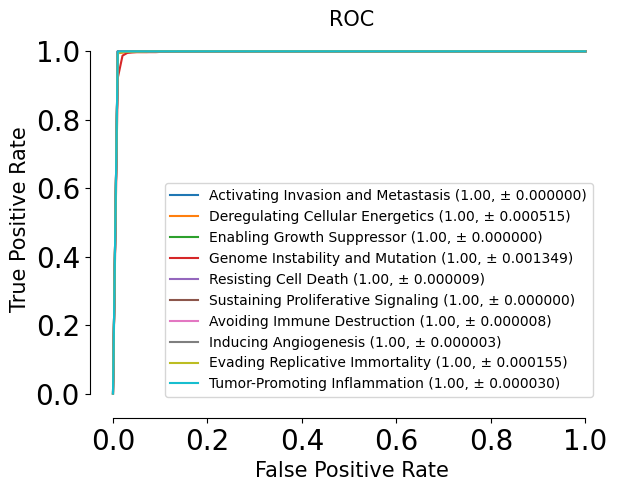

In [174]:
plt.figure()
for i in range(10):
    mean_pr_hall[i][0] = 0
    plt.plot(np.linspace(0, 1, 100), mean_pr_hall[i], label=f'{cancer_hallmarks.get(hall_list[i])} ({1 - mean_auc_hall[i]:.2f}, ± {std_auc_hall[i]:.6f})')
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC', fontsize=15)
plt.xlim([-0.02, 1.03])
plt.ylim([-0.03, 1.05])
sns.despine(right=True, top=True, offset=10, trim=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="lower right", prop={'size': 10})
plt.savefig('hallmark_roc_curve.png', dpi=1200, bbox_inches='tight')
plt.show()

In [126]:
fold_df1 = []
for i in range(10):
    fold_df2 = pd.DataFrame(results[i])
    fold_df2['Hallmark'] = hall_list[i]
    fold_df1.append(fold_df2)

fold_df3 = pd.concat(fold_df1, axis=0)
fold_df3.to_csv('hallmark_fold_metrics.csv', index=False)
fold_df3

,accuracy,precision,recall,f1,balanced_accuracy,cm,Hallmark
0,1.000000,1.000000,1.000000,1.000000,1.000000,"[[418, 0], [0, 337]]",AIM
1,0.986403,1.000000,0.971429,0.985507,0.985714,"[[424, 0], [11, 374]]",AIM
2,0.998549,1.000000,0.997312,0.998654,0.998656,"[[317, 0], [1, 371]]",AIM
3,0.981221,0.984496,0.984496,0.984496,0.980343,"[[82, 2], [2, 127]]",AIM
4,1.000000,1.000000,1.000000,1.000000,1.000000,"[[283, 0], [0, 259]]",AIM
...,...,...,...,...,...,...,...
5,1.000000,1.000000,1.000000,1.000000,1.000000,"[[379, 0], [0, 331]]",TPI
6,1.000000,1.000000,1.000000,1.000000,1.000000,"[[367, 0], [0, 283]]",TPI
7,1.000000,1.000000,1.000000,1.000000,1.000000,"[[433, 0], [0, 232]]",TPI
8,0.992337,0.993691,0.981308,0.987461,0.989271,"[[721, 2], [6, 315]]",TPI


In [3]:
fold_df3 = pd.read_csv('hallmark_fold_metrics.csv')
fold_df3

,accuracy,precision,recall,f1,balanced_accuracy,cm,Hallmark
0,1.000000,1.000000,1.000000,1.000000,1.000000,[[418 0]\n [ 0 337]],AIM
1,0.986403,1.000000,0.971429,0.985507,0.985714,[[424 0]\n [ 11 374]],AIM
2,0.998549,1.000000,0.997312,0.998654,0.998656,[[317 0]\n [ 1 371]],AIM
3,0.981221,0.984496,0.984496,0.984496,0.980343,[[ 82 2]\n [ 2 127]],AIM
4,1.000000,1.000000,1.000000,1.000000,1.000000,[[283 0]\n [ 0 259]],AIM
...,...,...,...,...,...,...,...
95,1.000000,1.000000,1.000000,1.000000,1.000000,[[379 0]\n [ 0 331]],TPI
96,1.000000,1.000000,1.000000,1.000000,1.000000,[[367 0]\n [ 0 283]],TPI
97,1.000000,1.000000,1.000000,1.000000,1.000000,[[433 0]\n [ 0 232]],TPI
98,0.992337,0.993691,0.981308,0.987461,0.989271,[[721 2]\n [ 6 315]],TPI


In [4]:
fold_df3_long = fold_df3.melt(
    id_vars='Hallmark',
    value_vars=['accuracy', 'precision', 'recall', 'f1', 'balanced_accuracy'],
    var_name='Metric',
    value_name='Value'
)
fold_df3_long

,Hallmark,Metric,Value
0,AIM,accuracy,1.000000
1,AIM,accuracy,0.986403
2,AIM,accuracy,0.998549
3,AIM,accuracy,0.981221
4,AIM,accuracy,1.000000
...,...,...,...
495,TPI,balanced_accuracy,1.000000
496,TPI,balanced_accuracy,1.000000
497,TPI,balanced_accuracy,1.000000
498,TPI,balanced_accuracy,0.989271


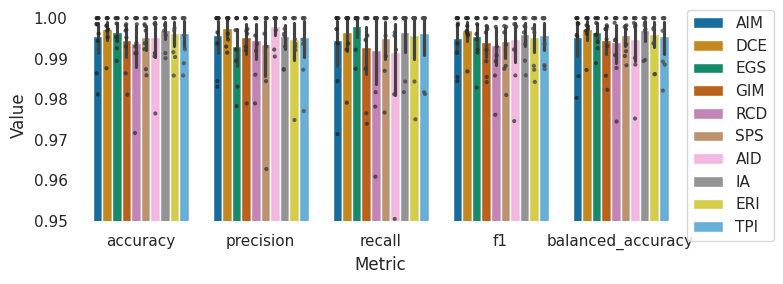

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 3))

sns.set(style='white')
# Base barplot
ax = sns.barplot(
    data=fold_df3_long,
    x="Metric",
    y="Value",
    hue="Hallmark",
    palette="colorblind",
    dodge=True
)

# Add individual data points using stripplot
sns.stripplot(
    data=fold_df3_long,
    x="Metric",
    y="Value",
    hue="Hallmark",
    dodge=True,
    palette="dark:.3",
    size=3,
    alpha=0.8,
    linewidth=0,
    ax=ax
)

# Remove the duplicate legend from stripplot
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:len(labels)//2], labels[:len(labels)//2], bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

# Y-axis zoom for clarity
plt.ylim(0.95, 1.002)
sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)
plt.tight_layout()
plt.savefig("cross_bar_plot.png", dpi=1200, bbox_inches='tight')
plt.show()

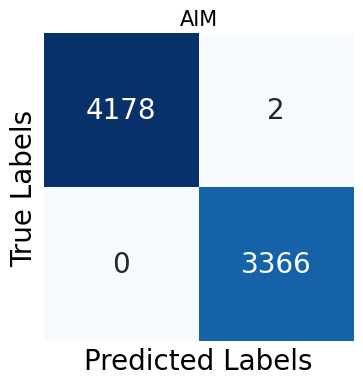

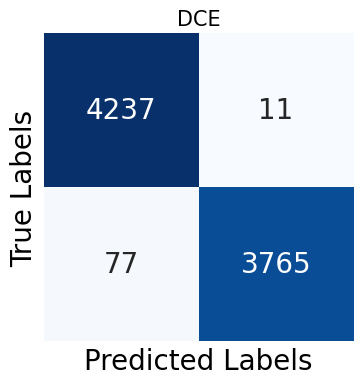

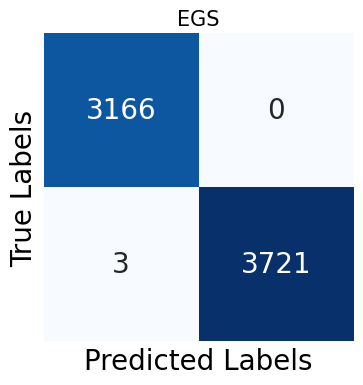

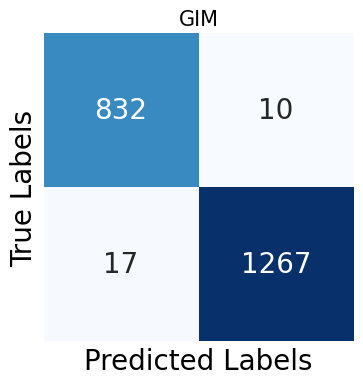

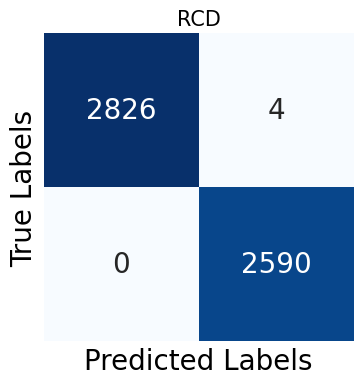

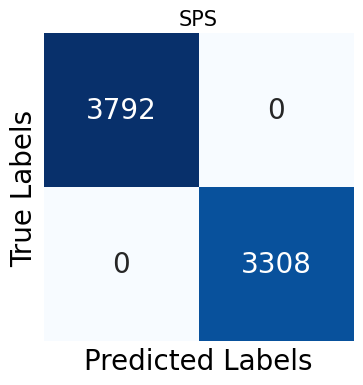

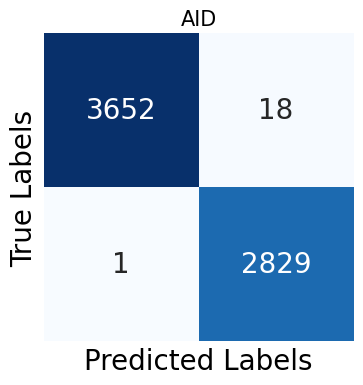

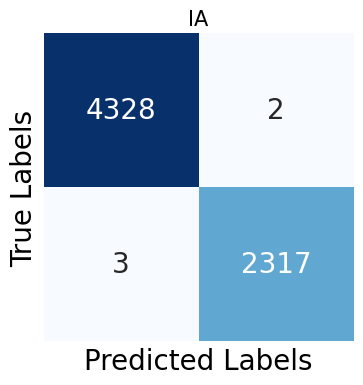

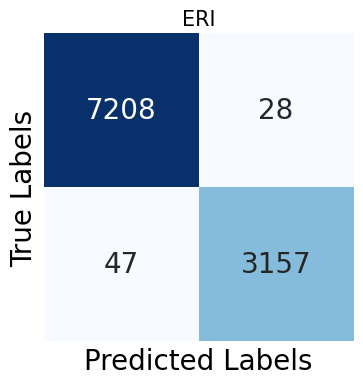

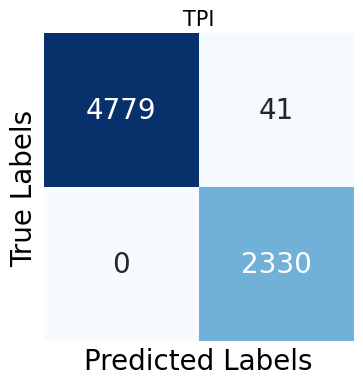

In [147]:
avg_results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'balanced_accuracy': []
}

# Compute the average metric for each label across all folds
for label_idx in range(10):
    avg_results['accuracy'].append(np.mean([fold['accuracy'][label_idx] for fold in results]))
    avg_results['precision'].append(np.mean([fold['precision'][label_idx] for fold in results]))
    avg_results['recall'].append(np.mean([fold['recall'][label_idx] for fold in results]))
    avg_results['f1'].append(np.mean([fold['f1'][label_idx] for fold in results]))
    avg_results['balanced_accuracy'].append(np.mean([fold['balanced_accuracy'][label_idx] for fold in results]))
    cm = np.sum([fold['cm'][label_idx] for fold in results], axis=0)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                cbar=False, annot_kws={"size": 20})
    plt.xlabel('Predicted Labels', fontsize=20)
    plt.ylabel('True Labels', fontsize=20)
    # plt.xticks(fontsize=20)
    # plt.yticks(fontsize=20, rotation=0)
    plt.xticks([])  # Remove x-ticks
    plt.yticks([])  # Remove y-ticks
    plt.title(hall_list[label_idx], fontsize=15)
    plt.savefig('hallmark_cm_{}.png'.format(hall_list[label_idx]), dpi=1200, bbox_inches='tight')
    plt.show()

In [148]:
result_df = pd.DataFrame(avg_results, index=hall_list)
result_df.to_csv('hallmark_avg_metrics.csv')
result_df

,accuracy,precision,recall,f1,balanced_accuracy
AIM,0.999735,0.999408,1.000000,0.999704,0.999761
DCE,0.989122,0.997113,0.979959,0.988409,0.988685
EGS,0.999565,1.000000,0.999195,0.999597,0.999597
GIM,0.987289,0.992222,0.986761,0.989429,0.987435
RCD,0.999262,0.998462,1.000000,0.999229,0.999293
SPS,1.000000,1.000000,1.000000,1.000000,1.000000
AID,0.997077,0.993696,0.999647,0.996657,0.997371
IA,0.999248,0.999142,0.998707,0.998922,0.999123
ERI,0.992816,0.991242,0.985337,0.988262,0.990734
TPI,0.994266,0.982800,1.000000,0.991302,0.995747


# Repeated K-fold Done

# Final Model for inference purposes

In [113]:
def combine_data(data):
    x_combined = np.vstack([d[0] for d in data])
    y_combined = np.hstack([d[1] for d in data])
    t_combined = np.hstack([d[2] for d in data])
    return x_combined, y_combined, t_combined

def combine_and_shuffle(data):
    x_combined, y_combined, t_combined = combine_data(data)
    x_shuffled, y_shuffled, t_shuffled = shuffle(x_combined, y_combined, t_combined, random_state=42)
    return x_shuffled, y_shuffled, t_shuffled

In [18]:
train_data, val_data = [], []
for x, y, t in datasets:
    x_train, x_val, y_train, y_val, t_train, t_val = train_test_split(
        np.array(x), np.array(y), np.array(t), test_size=0.15, random_state=42, shuffle=True
    )
    train_data.append((x_train, y_train, t_train))
    val_data.append((x_val, y_val, t_val))

In [19]:
x_train, y_train, t_train = combine_and_shuffle(train_data)
x_val, y_val, t_val = combine_and_shuffle(val_data)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

In [20]:
joblib.dump(scaler, 'hallmark_scaler.joblib')

['hallmark_scaler.joblib']

In [21]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((57735, 9326), (57735,), (10195, 9326), (10195,))

In [22]:
t_train_one_hot = tf.keras.utils.to_categorical(t_train, 10)
t_val_one_hot = tf.keras.utils.to_categorical(t_val, 10)

In [24]:
# model training
model, train_loss, val_loss = train_model(
    x_train, y_train, t_train_one_hot, 
    x_val, y_val, t_val_one_hot, 
    input_shape=(9326,), num_tasks=10, 
    batch_size=256, epochs=50, 
    learning_rate=0.0001, 
    patience=5, lr_patience=3, 
    lr_factor=0.5, min_lr=1e-6,
    save=True,
    model_save_path='hallmark_model.keras'
)

I0000 00:00:1733467221.201095 2069520 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1313 MB memory:  -> device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:51:00.0, compute capability: 8.6
I0000 00:00:1733467221.201575 2069520 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10286 MB memory:  -> device: 1, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:c3:00.0, compute capability: 8.6



Epoch 1/50
Training Loss: 0.01809973083436489
Validation Loss: 0.00995550025254488
Validation loss improved. Resetting patience and learning rate patience.

Epoch 2/50
Training Loss: 0.007344808429479599
Validation Loss: 0.005679363384842873
Validation loss improved. Resetting patience and learning rate patience.

Epoch 3/50
Training Loss: 0.0041839745827019215
Validation Loss: 0.0037055721040815115
Validation loss improved. Resetting patience and learning rate patience.

Epoch 4/50
Training Loss: 0.002674839226529002
Validation Loss: 0.002753583015874028
Validation loss improved. Resetting patience and learning rate patience.

Epoch 5/50
Training Loss: 0.0018795407377183437
Validation Loss: 0.0022556339390575886
Validation loss improved. Resetting patience and learning rate patience.

Epoch 6/50
Training Loss: 0.0014195600524544716
Validation Loss: 0.001961181638762355
Validation loss improved. Resetting patience and learning rate patience.

Epoch 7/50
Training Loss: 0.00110774300992

In [25]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 9326)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │    596,928 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │      1,040 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │      1,040 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16)        │      1,040 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 16)        │      1,040 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 16)        │      1,040 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 16)        │      1,040 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 16)        │      1,040 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 16)        │      1,040 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 16)        │      1,040 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 16)        │      1,040 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         17 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         17 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         17 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         17 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │         17 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │         17 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │         17 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1)         │         17 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 1)         │         17 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 1)         │         17 │ dense_19[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,822,496 (6.95 MB)

 Trainable params: 607,498 (2.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,214,998 (4.63 MB)

In [73]:
loss_data = pd.DataFrame([train_loss, val_loss]).T
loss_data.columns = ['Training', 'Validation']
loss_data.index.name = 'Epochs'
loss_data.to_csv('hallmark_model_loss.csv')

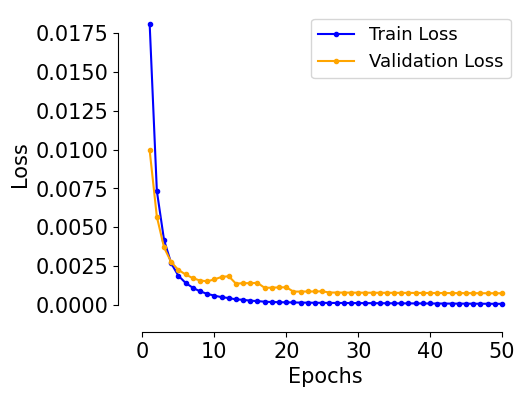

In [72]:
epochs = range(1, 51)
plt.figure(figsize=(5, 4))
plt.plot(epochs, train_loss, label='Train Loss', marker='.', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', marker='.', color='orange')

# Adding labels, title, and legend
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
# plt.title('Training and Validation Loss', fontsize=15)
sns.despine(right=True, top=True, offset=10, trim=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc="upper right", prop={'size': 13})
plt.savefig('hallmark_model_loss.png', dpi=1200, bbox_inches='tight')
plt.show()

# Model Training Done

# Inference

In [ ]:
scaler = joblib.load('hallmark_scaler.joblib')
scaler

In [ ]:
with open("hallmark_feature.txt", "r") as file:
    features = [line.strip() for line in file]

In [ ]:
model = tf.keras.models.load_model('hallmark_model.keras')
model.summary()